<a href="https://colab.research.google.com/github/chrisgraham631/D2P/blob/main/ROS_WRFSFIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# given fuel params
fuel = {'windrf': [0.1], 'fgi': 1, 'fueldepthm': 1,'savr': 109, 'fuelmce': 0.05, 'fueldens':  0.1,
        'st': 0.055, 'se': 0.01, 'weight': 0.1, 'fci_d': 1, 'fct': 1, 'ichap': 0, 'fci': 1, 'fcbr': 1, 
        'hfgl': 1, 'fuelheat': 8000, 'fuelmc_g': 1, 'fuelmc_c': 1, 'cmbcnst': 1}
fuel = pd.DataFrame(fuel)

#fuel.windrf = 0.1               # WIND REDUCTION FACTOR
#fuel.fgi    = [1];                     # INITIAL TOTAL MASS OF SURFACE FUEL (KG/M**2)
#fuel.fueldepthm = 1       # FUEL DEPTH (M)
#fuel.savr   = 109                   # FUEL PARTICLE SURFACE-AREA-TO-VOLUME RATIO, 1/FT
#fuel.fuelmce = 0.05         # MOISTURE CONTENT OF EXTINCTION
#fuel.fueldens = 0.1           # OVENDRY PARTICLE DENSITY, LB/FT^3
#fuel.st     =   0.0555                     # FUEL PARTICLE TOTAL MINERAL CONTENT
#fuel.se  = 0.01                       # FUEL PARTICLE EFFECTIVE MINERAL CONTENT
#fuel.weight = 0.1             # WEIGHTING PARAMETER THAT DETERMINES THE SLOPE OF THE MASS LOSS CURVE
#fuel.fci_d = 1                # INITIAL DRY MASS OF CANOPY FUEL
#fuel.fct   = 1                   # BURN OUT TIME FOR CANOPY FUEL, AFTER DRY (S)
#fuel.ichap = 0                # 1 if chaparral, 0 if not
#fuel.fci   = 1                   # INITIAL TOTAL MASS OF CANOPY FUEL
#fuel.fcbr = 1                   # FUEL CANOPY BURN RATE (KG/M**2/S)
#fuel.hfgl = 1                # SURFACE FIRE HEAT FLUX THRESHOLD TO IGNITE CANOPY (W/m^2)
#fuel.cmbcnst = 1             # JOULES PER KG OF DRY FUEL
#fuel.fuelheat = 8000        # FUEL PARTICLE LOW HEAT CONTENT, BTU/LB
#fuel.fuelmc_g1 = 1           # FUEL PARTICLE (SURFACE) MOISTURE CONTENT, jm: 1 by weight?
#fuel.fuelmc_c =1           # FUEL PARTICLE (CANOPY) MOISTURE CONTENT, 1

print(fuel.ichap[0])

0


In [ ]:
def fire_ros(fuel,speed,tanphi):
  # ros=fire_ros(fuel,speed,tanphi)
  # ros=fire_ros(fuel,speed,tanphi,fmc_g)
  # in
  #       fuel    fuel description structure
  #       speed   wind speed
  #       tanphi  slope
  #       fmc_g   optional, overrides fuelmc_g from the fuel description
  # out
  #       ros     rate of spread

  # given fuel params
  windrf=fuel.windrf;               # WIND REDUCTION FACTOR
  fgi=fuel.fgi;                     # INITIAL TOTAL MASS OF SURFACE FUEL (KG/M**2)
  fueldepthm=fuel.fueldepthm;       # FUEL DEPTH (M)
  savr=fuel.savr;                   # FUEL PARTICLE SURFACE-AREA-TO-VOLUME RATIO, 1/FT
  fuelmce=fuel.fuelmce;             # MOISTURE CONTENT OF EXTINCTION
  fueldens=fuel.fueldens;           # OVENDRY PARTICLE DENSITY, LB/FT^3
  st=fuel.st;                       # FUEL PARTICLE TOTAL MINERAL CONTENT
  se=fuel.se;                       # FUEL PARTICLE EFFECTIVE MINERAL CONTENT
  weight=fuel.weight;               # WEIGHTING PARAMETER THAT DETERMINES THE SLOPE OF THE MASS LOSS CURVE
  fci_d=fuel.fci_d;                 # INITIAL DRY MASS OF CANOPY FUEL
  fct=fuel.fct;                     # BURN OUT TIME FOR CANOPY FUEL, AFTER DRY (S)
  ichap=fuel.ichap;                 # 1 if chaparral, 0 if not
  fci=fuel.fci;                     # INITIAL TOTAL MASS OF CANOPY FUEL
  fcbr=fuel.fcbr;                   # FUEL CANOPY BURN RATE (KG/M**2/S)
  hfgl=fuel.hfgl;                   # SURFACE FIRE HEAT FLUX THRESHOLD TO IGNITE CANOPY (W/m^2)
  cmbcnst=fuel.cmbcnst;             # JOULES PER KG OF DRY FUEL
  fuelheat=fuel.fuelheat;           # FUEL PARTICLE LOW HEAT CONTENT, BTU/LB
  fuelmc_g=fuel.fuelmc_g;           # FUEL PARTICLE (SURFACE) MOISTURE CONTENT, jm: 1 by weight?
  fuelmc_c=fuel.fuelmc_c;           # FUEL PARTICLE (CANOPY) MOISTURE CONTENT, 1

#if exist('fmc_g','var'): # override moisture content by given
    #fuelmc_g = fmc_g;
    ##wont use##


  # computations from CAWFE code: wf2_janice/fire_startup.m4 

  bmst     = fuelmc_g/(1+fuelmc_g);          # jm: 1 
  fuelheat = cmbcnst * 4.30e-04;             # convert J/kg to BTU/lb
  fci      = (1+fuelmc_c)*fci_d;
  fuelloadm= (1-bmst) * fgi;                # fuelload without moisture
                                           # jm: 1.-bmst = 1/(1+fuelmc_g) so fgi includes moisture? 
  fuelload = fuelloadm * (.3048)**2 * 2.205;  # to lb/ft^2
  fueldepth= fueldepthm/0.3048;              # to ft
  betafl   = fuelload/(fueldepth * fueldens);# packing ratio  jm: lb/ft^2/(ft * lb*ft^3) = 1
  betaop   = 3.348 * savr**(-0.8189);         # optimum packing ratio jm: units??  
  qig      = 250 + 1116*fuelmc_g;          # heat of preignition, btu/lb
  epsilon  = np.exp(-138/savr );               # effective heating number
  rhob     = fuelload/fueldepth;             # ovendry bulk density, lb/ft^3
  c        = 7.47 * np.exp(-0.133 * savr**0.55); # const in wind coef
  bbb      = 0.02526 * savr**0.54;            # const in wind coef
  c        = c * windrf**bbb;                 # jm: wind reduction from 20ft per Baughman&Albini(1980)
  e        = 0.715 * np.exp( -3.59e-4 * savr);  # const in wind coef
  phiwc    = c * (betafl/betaop)**(-e); 
  rtemp2   = savr**1.5;
  gammax   = rtemp2/(495. + 0.0594*rtemp2);  # maximum rxn vel, 1/min
  a        = 1./(4.774 * savr**0.1 - 7.27);   # coef for optimum rxn vel
  ratio    = betafl/betaop;   
  gamma    = gammax*(ratio**a)*np.exp(a*(1-ratio)); # optimum rxn vel, 1/min
  wn       = fuelload/(1 + st);              # net fuel loading, lb/ft^2
  rtemp1   = fuelmc_g/fuelmce;
  etam     = 1.-2.59*rtemp1 +5.11*rtemp1**2 -3.52*rtemp1**3;  # moist damp coef
  etas     = 0.174* se**(-0.19);              # mineral damping coef
  ir       = gamma * wn * fuelheat * etam * etas; # rxn intensity,btu/ft^2 min
  irm      = ir * 1055/( 0.3048**2 * 60) * 1e-6; # for mw/m^2 (set but not used)
  xifr     = np.exp( (0.792 + 0.681*savr**0.5)* (betafl+0.1)) /(192 + 0.2595*savr); # propagating flux ratio r_0 is the spread rate for a fire on flat ground with no wind.
  r_0      = ir*xifr/(rhob * epsilon *qig);  # default spread rate in ft/min

  # computations from CAWFE code: wf2_janice/fire_ros.m4 
  if not ichap[0]:
    #       ... if wind is 0 or into fireline, phiw = 0, &this reduces to backing ros.
 
    spdms = max(speed,0);
    umidm = min(spdms,30);                    # max input wind spd is 30 m/s   !param!
    umid = umidm * 196.850;                    # m/s to ft/min
    #  eqn.: phiw = c * umid**bbb * (betafl/betaop)**(-e) ! wind coef
    phiw = umid**bbb * phiwc;                   # wind coef
    phis = 5.275 * betafl**(-0.3) *max(0,tanphi)**2;   # slope factor
    ros = r_0*(1 + phiw + phis)  * .00508; # spread rate, m/s
  else:  # chapparal'''
    #        .... spread rate has no dependency on fuel character, only windspeed.
    spdms = max(speed,0);
    ros = max(.03333,1.2974 * spdms**1.41);       # spread rate, m/s

    ros=min(ros,6);
  return ros

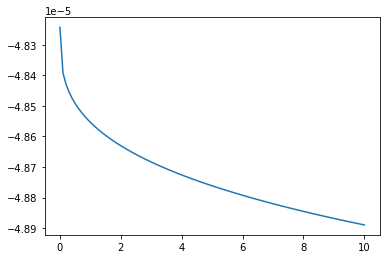

In [ ]:
wind = np.linspace(0,10,100);
ros  = np.zeros((len(wind),1));
for i, val in enumerate(wind):
  ros[i] = fire_ros(fuel,val,5);
plt.plot(wind, ros);